In [1]:
import sys
import os
module_path = os.path.abspath('/media/jary/DATA/Uni/tesi/codice')

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from networks import NoKafnet, Kafnet
import utils.datasetsUtils.CIFAR as CIFAR
from utils.datasetsUtils.taskManager import IncrementalTaskClassification, NoTask
import configs.configClasses as configClasses
from torchvision.transforms import transforms
import torch
import matplotlib
import networks.continual_learning as continual_learning
import networks.continual_learning_beta as continual_learning_beta
from pylab import rcParams
from Trainer import Trainer
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import brewer2mpl
import pandas as pd


In [3]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [4]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
1
GeForce GTX 1050


In [5]:
config = configClasses.DefaultConfig()
config.L1_REG = 0
config.EPOCHS = 10
config.SAVE_PATH = './models/ann'
config.IS_CONVOLUTIONAL = True
config.USE_CL = False
config.BATCH_SIZE = 32
config.MODEL_NAME = ''
config.NEXT_TASK_EPOCHS = None
config.NEXT_TASK_LR = None
config.OPTIMIZER = 'Adam'
print(config)

CONFIG PARAMETERS
BATCH_SIZE: 32
CL_PAR: {'sample_size': 250, 'penalty_importance': 1000.0}
CL_TEC: <class 'networks.continual_learning.EWC'>
DEVICE: cuda
EPOCHS: 10
IS_CONVOLUTIONAL: True
IS_INCREMENTAL: True
ITERS: 1
L1_REG: 0
LOSS: cross_entropy
LR: 0.001
MODEL_NAME: 
NEXT_TASK_EPOCHS: None
NEXT_TASK_LR: None
OPTIMIZER: Adam
RUN_NAME: default
SAVE_PATH: ./models/ann
USE_CL: False
USE_TENSORBOARD: True



In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
)

dataset = CIFAR.Cifar10('../data/cifar10', download=True, transform=transform, 
                        task_manager=IncrementalTaskClassification(2),
                        force_download=False, train_split=0.8, target_transform=None)
dataset.load_dataset()
print(len(dataset.Y))

../data/cifar10/download
60000


In [7]:
net = NoKafnet.synCNN(10)

In [8]:
experiments = [('no_cont_learning', None),
               ('ewc', continual_learning.OnlineEWC),
               ('gem', continual_learning.GEM_MEM),
               ('embedding', continual_learning.embedding)]

In [ ]:
results = []
res = {}
EXPERIMENTS = 5

for i in range(EXPERIMENTS):
    for name, tec in experiments:        
        n = deepcopy(net)
        c = deepcopy(config)

        c.MODEL_NAME = name+'_'+str(i) 
        print(c.MODEL_NAME)

        if name == 'gem':
            c.CL_PAR = {'memorized_task_size': 100, 'sample_size': 50,'margin': 0.5}
            c.USE_CL = True
        elif name == 'ewc':
            c.CL_PAR = {'penalty_importance': 2e3, 'sample_size': 200}
            c.USE_CL = True
        elif name == 'embedding':
            c.CL_PAR = {'penalty_importance': 1, 'weights_type': 'distance', 
                        'sample_size': 30, 'distance': 'cosine','memorized_task_size': 100}
            c.USE_CL = True

        c.CL_TEC = tec
        trainer = Trainer(n, deepcopy(dataset), c, save_modality=2, verbose=False)

        r = trainer.load()
        if not r:
            r = trainer.all_tasks()
        print(r['metrics'])
        
        if name not in res:
            res[name] = [r]
        else:
            res[name].append(r)
        
        del trainer
        del n

In [10]:
for k, v in res.items():
    r = {}
    metrics = {}
    acc = {}
    std = []
    
    EXP = len(v)

    for vv in v:
        if len(metrics) == 0:
            metrics = vv['metrics']
        else:
            for mk in vv['metrics'].keys():
                metrics[mk] += vv['metrics'][mk]

        if len(acc) == 0:
            acc = vv['tasks']
        else:
            for t in vv['tasks']:
                acc[t]['accuracy'] = [ac + vv['tasks'][t]['accuracy'][i] for i, ac in enumerate(acc[t]['accuracy'])]
        

        s = []
        for _, t in vv['tasks'].items():
            s.append(t['accuracy'])
        
        std.append(s)
            
    for i, v in metrics.items():
        metrics[i] = v / EXP
    
    for i, v in acc.items():
        p = [ i/EXP for i in acc[i]['accuracy']]
        acc[i]['accuracy'] = p
    
    rstd = {}
    
    std = list(zip(*std))
    for i in range(len(std)):
        t = np.asarray(std[i]).T
        rstd[str(i)] = list(np.std(t, 1))

    results.append((k, {'metrics': metrics, 'tasks': acc, 'std': rstd}))

In [11]:
print('RESULTS')
for name, r in results:
    print(name, r['metrics'])
    print()

RESULTS
no_cont_learning {'fwt': 0.38517499999999993, 'bwt': -0.3451166666666666, 'remembering': 0.6548833333333334, 'pbwt': 0.0, 'accuracy': 0.6858555555555557}

ewc {'fwt': 0.3772583333333333, 'bwt': -0.21438333333333331, 'remembering': 0.7856166666666666, 'pbwt': 0.0, 'accuracy': 0.654961111111111}

gem {'fwt': 0.40803333333333336, 'bwt': -0.11827499999999999, 'remembering': 0.8817250000000001, 'pbwt': 0.0, 'accuracy': 0.8127333333333333}

embedding {'fwt': 0.3324166666666667, 'bwt': -0.11941666666666666, 'remembering': 0.8805833333333333, 'pbwt': 0.0, 'accuracy': 0.8328555555555555}



In [12]:
params = {
   'axes.labelsize': 12,
   'font.family': 'Times New Roman',
   'font.size': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   'figure.figsize': [4, 3]
   }
rcParams.update(params)
matplotlib.rc('pdf', fonttype=42)

# brewer2mpl.get_map args: set name  set type  number of colors
bmap = brewer2mpl.get_map('Set2', 'qualitative', 8)

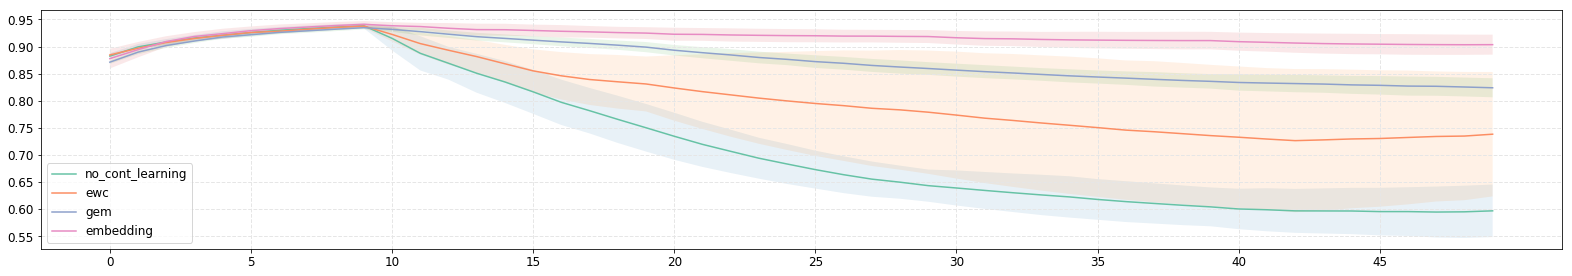

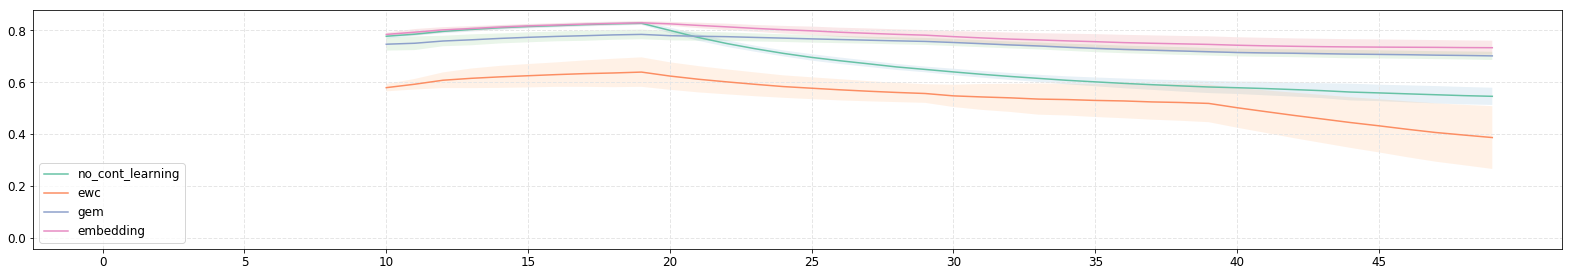

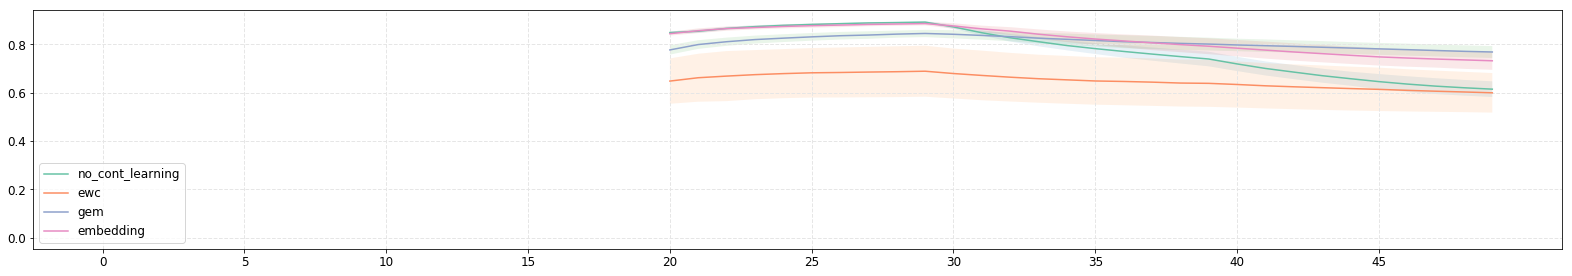

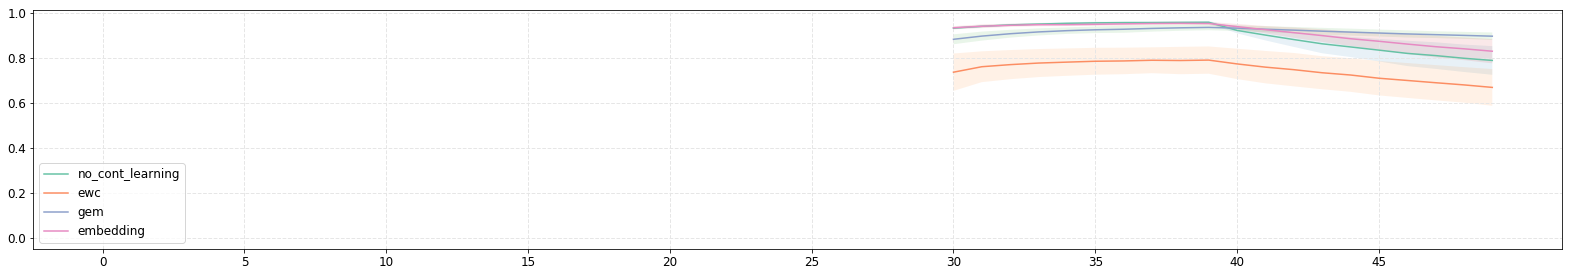

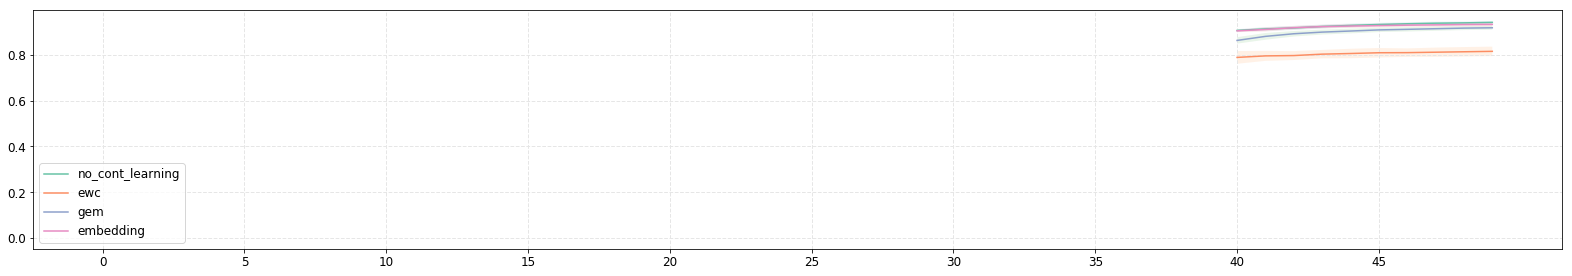

In [16]:
n_task = len(results[0][1]['tasks'])

tot_epochs = 0

for _, r in results:
    for k, v in r['tasks'].items():
        tot_epochs = max(tot_epochs, len(v['accuracy']))

figures = {}
colors = iter(bmap.mpl_colors)

for name, r in results:
    c = next(colors)
    for i, task in enumerate(r['tasks'].keys()):

        com = r['tasks'][task]

        x = range(tot_epochs-len(com['accuracy']), tot_epochs)
        acc = [0] * (tot_epochs-len(com['accuracy']))

        plt.figure(i, figsize=(22, 4))

        plt.axes().yaxis.set_tick_params(which='minor', right = 'off')
        plt.xticks(range(0, tot_epochs, 5))
        
        tr, = plt.plot(range(tot_epochs-len(com['accuracy'])), acc, color=c)
        
        to_plot =  pd.DataFrame(com['accuracy']).ewm(halflife=14).mean().values.T.tolist()[0]
        
        plt.plot(x, to_plot, label=name, color=c)
        tr.remove()
        plt.legend(loc="lower left")
        plt.grid(True, axis='both', color="0.9", linestyle='--', linewidth=1)
        
        std_to_plot = pd.DataFrame(r['std'][str(task)]).ewm(halflife=14).mean().values.T.tolist()[0]
        plt.fill_between(x, np.asarray(to_plot)-np.asarray(std_to_plot), 
                         np.asarray(to_plot)+np.asarray(std_to_plot), alpha=0.1)
        
        plt.legend(loc='lower left')
        
        plt.tight_layout()
        

for i in plt.get_fignums():
    plt.figure(i, figsize=(22, 4))
    plt.savefig('{}/cifar10_ann_task{}.pdf'.format(config.SAVE_PATH, i), bbox_inches='tight', pad_inches=0)
    